In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [2]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

In [3]:
from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde
from utility import display_components,display_pca_data


In [4]:
import holoviews as hv
hv.notebook_extension()

from bqplot import (
    LogScale, LinearScale, OrdinalColorScale, ColorAxis,
    Axis, Scatter, Lines, CATEGORY10, Label, Figure, Tooltip, Hist
)

from ipywidgets import HBox, VBox, IntSlider, Play, jslink, Layout, Dropdown
import ipywidgets
%matplotlib inline

In [5]:
%%time

dataset_name = "W13_comb"

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

filename = manifest["Stata_Filename"].values[0]

BES_Panel = pd.read_stata( data_subfolder + filename )
print("BES_Panel", BES_Panel.shape )

####

BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
print("BES_numeric",  BES_numeric.shape )

var_type    = pd.read_hdf( data_subfolder + "var_type.hdf", "var_type" )
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
print("BES_non_numeric",  BES_non_numeric.shape )

BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
print("BES_reduced",  BES_reduced.shape )

BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
print("BES_reduced_with_na", BES_reduced_with_na.shape )

fname = data_subfolder + "new_old_col_names.pkl"
with open(fname, "rb") as f:
    new_old_col_names = pickle.load(f) 

BES_Panel (69486, 5173)
BES_numeric (69486, 4993)
var_type (5173, 12)
BES_non_numeric (69486, 125)
BES_reduced (69486, 2526)
BES_reduced_with_na (69486, 2526)
Wall time: 18min 26s


In [6]:
# wave = "W13_only"

# BES_numeric = pd.read_hdf( BES_data_folder+"BESnumeric"+wave+".hdf", "BESnumeric"+wave )
# print("BES_numeric",  BES_numeric.shape )
# var_type    = pd.read_hdf( BES_data_folder+"var_type"+wave+".hdf", "var_type" )
# print("var_type",  var_type.shape )
# BES_reduced = pd.read_hdf( BES_data_folder+"BES_reduced"+wave+".hdf", "BES_reduced"+wave )
# print("BES_reduced",  BES_reduced.shape )

# fname = BES_data_folder+"cat_dictionary"+wave+".pkl"
# with open(fname, "rb") as f:
#     cat_dictionary = pickle.load( f )

In [7]:
# fulldata_withPP - all samples, no columns removed due to NAs, preprocessing for weasel answers
# procdata_withPP - light cleaning
# mostdata_withPP - imputation on reduced set, 2% least filled removed
# lessdata_withPP - imputation on reduced set (% lesast filled), but only retain 2/3 filled out data
# core_withPP - just the representative cross-section core



Treatment = dataset_name
output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [8]:
# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(BES_reduced.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_reduced.columns,
                             index   = BES_reduced.index      )

In [9]:
%%time
# 5 mins
## RUN (some variant of) PCA (potentially v slow!)

# (svd_solver='full', n_components='mle',whiten=True)
#decomp = PCA(svd_solver='full')
#decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
 #    n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=30, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr
decomp = FactorAnalysis(svd_method = 'lapack') ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)
n_components = decomp.components_.shape[0]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_reduced.index)

Wall time: 4min 9s


In [10]:
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = False # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + os.sep + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    BES_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

In [11]:
# # %%time
# # import importlib.util
# # import utility
# # importlib.reload(utility)
# # from utility import display_components

# import imp; imp.reload(utility)
# del display_pca_data
# from utility import display_pca_data

average log-likelihood of all samples: -2921.06236433
number of iterations: 2


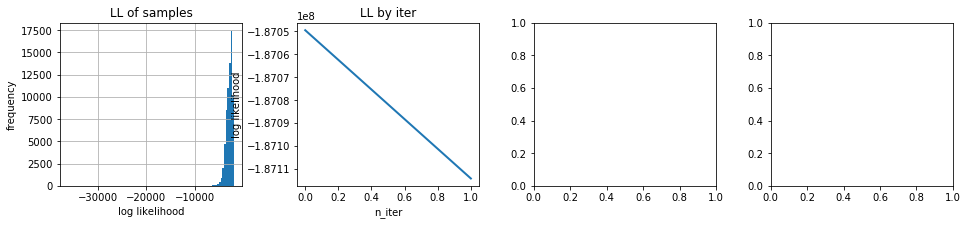

In [12]:
display_pca_data(n_components, decomp, BES_std)

In [13]:
# del display_components

In [14]:
# 0.07954041   0.03892755   0.03553862   0.01885494    0.01562524  
# 50.4286187   24.68006591  22.53148776  11.95403344   9.90639926

In [15]:
# def display_components(n_components, decomp, folder, cols, BES_decomp):

#     n_comps = min(n_components,20)
#     comp_labels = {}
#     comp_dict = {}

#     for comp_no in range(0,n_comps):

#         fig, axes = plt.subplots(ncols=2)

#         ax = axes[1]
#         comp = pd.DataFrame( decomp.components_[comp_no], index = cols, columns = ["components_"] )
#         comp["comp_absmag"] = comp["components_"].abs()
#         comp = comp.sort_values(by="comp_absmag",ascending=True)
        
#         ax.set_xlabel("abs. variable coeffs")
#         ax.set_title("Histogram of abs. variable coeffs")
#         comp["comp_absmag"].hist( bins=30, ax=ax, figsize=(10,6) )

#         # set top abs_mag variable to label
#         comp_labels[comp_no] = comp.index[-1:][0] # last label (= highest magnitude)
#         # if top abs_mag variable is negative
#         if comp[-1:]["components_"].values[0] < 0:
#             comp["components_"]         = -comp["components_"]
#             decomp.components_[comp_no] = -decomp.components_[comp_no]
#             BES_decomp[comp_no]         = -BES_decomp[comp_no]

#         ax = axes[0]
#         title = "Comp. "+str(comp_no)+" (" + comp.index[-1:][0] + ")"
#         comp_labels[comp_no] = title
#         ax.set_title( title )
#         ax.set_xlabel("variable coeffs")
#         xlim = (min(comp["components_"].min(),-1) , max(comp["components_"].max(),1) )
#         comp["components_"].tail(30).plot( kind='barh', ax=ax,figsize=(10,6), xlim=xlim )

# #         print(title)
#         fname = folder + title.replace("/","_").replace(":","_") + ".png"
# #         print(fname)
#         fig.savefig( fname, bbox_inches='tight' )

#         comp_dict[comp_no] = comp
#         plt.close()
        
#     return (BES_decomp, comp_labels, comp_dict)

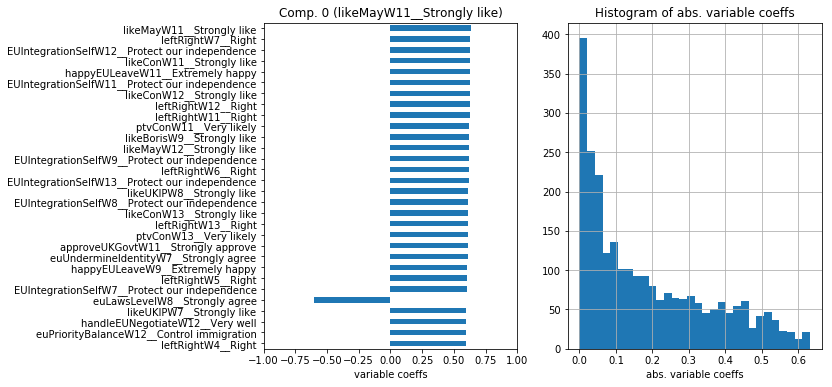

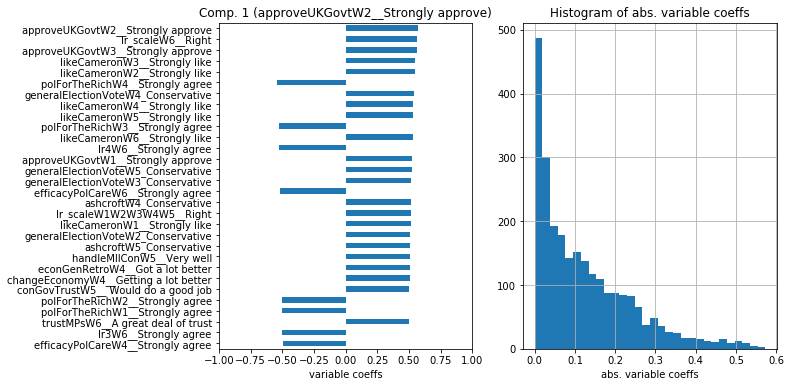

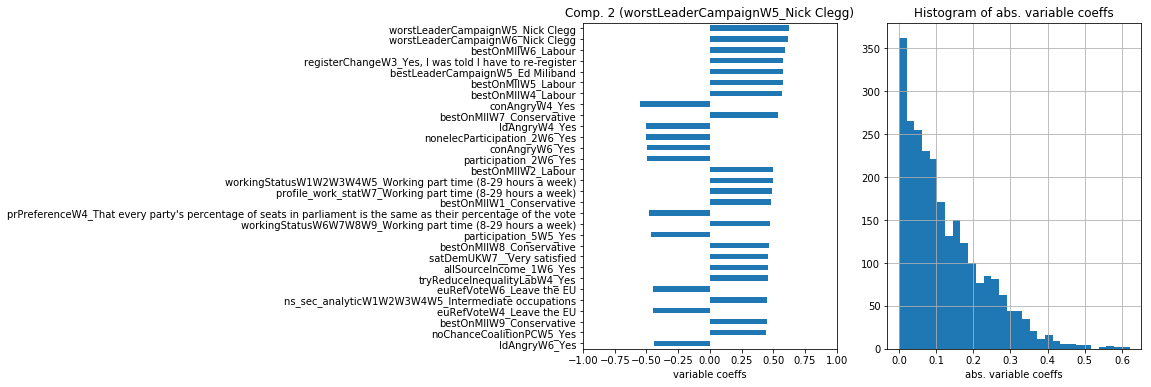

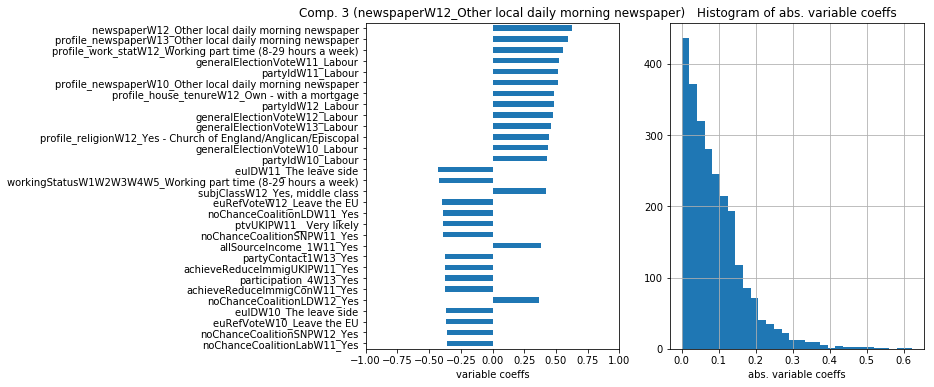

In [16]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_reduced.columns, BES_decomp,
                                                          save_folder = subdir, 
                                                          show_first_x_comps= 4, show_histogram = True)

In [17]:
# # returns = np.log(prices[1:]) - np.log(prices[:-1])
# hist_x = LinearScale()
# hist_y = LinearScale()
# hist = Hist(sample=comp["comp_absmag"], scales={'sample': hist_x, 'count': hist_y}, bins=30)

# hist_x.min=0
# hist_x.max=1

# h_xax = Axis(scale=hist_x, label='abs. variable coeffs', grids='off', set_ticks=True)
# h_yax = Axis(scale=hist_y, label='Freq', orientation='vertical', grid_lines='none')

# layout=ipywidgets.Layout(min_width='1000px', min_height='200px')

# fig_hist = Figure( marks=[hist], axes=[h_xax, h_yax], title='histogram of abs. variable coeffs',
#                    layout = layout, min_height='200px', preserve_aspect=False )
# fig_hist

In [18]:
from bqplot import DateScale, LinearScale, OrdinalScale, Axis, Lines, Scatter, Bars, Hist, Figure

comp_slider = IntSlider(min=0, max=19, step=1, description='Component', value=0)
def comp_changed(change):
    comp = comp_dict[comp_slider.value]
    fig_lasso.title = "Comp. "+str(comp_slider.value)+" (" + comp.index[-1:][0] + ")"
    bar_lasso.x = comp["components_"].tail(30).index
    bar_lasso.y = comp["components_"].tail(30).values
    
comp_slider.observe(comp_changed, 'value')

comp = comp_dict[0]
x = comp["components_"].tail(30).index
y = comp["components_"].tail(30).values



title = "Comp. "+str(comp_slider.value)+" (" + comp.index[-1:][0] + ")"

xs, ys = OrdinalScale(), LinearScale()
ys.min = -1
ys.max = 1

data = np.arange(20)
bar_lasso = Bars(x=x, y=y, scales={'x': xs, 'y': ys}, orientation='horizontal',font_size = '30px')
xax_lasso = Axis(scale=xs, orientation='vertical')
yax_lasso = Axis(scale=ys, label='variable coeffs', orientation='horizontal')
fig_margin = dict(top=60, bottom=60, left=320, right=60)
layout=ipywidgets.Layout(min_width='1000px', min_height='600px')
fig_lasso = Figure(marks=[ bar_lasso], axes=[xax_lasso, yax_lasso],
                   title=title, fig_margin = fig_margin,
                   layout=layout)


box_layout = Layout(display='flex',
                    flex_flow='column',
                    align_items='center')

VBox([ fig_lasso,  comp_slider ], layout = box_layout)

VBox(children=(Figure(axes=[Axis(orientation='vertical', scale=OrdinalScale()), Axis(label='variable coeffs', scale=LinearScale(max=1.0, min=-1.0))], fig_margin={'top': 60, 'bottom': 60, 'left': 320, 'right': 60}, layout=Layout(min_height='600px', min_width='1000px'), marks=[Bars(colors=['steelblue'], interactions={'hover': 'tooltip'}, orientation='horizontal', scales={'x': OrdinalScale(), 'y': LinearScale(max=1.0, min=-1.0)}, scales_metadata={'x': {'orientation': 'vertical', 'dimension': 'x'}, 'y': {'orientation': 'horizontal', 'dimension': 'y'}}, tooltip_style={'opacity': 0.9}, x=array(['leftRightW4__Right', 'euPriorityBalanceW12__Control immigration',
       'handleEUNegotiateW12__Very well', 'likeUKIPW7__Strongly like',
       'euLawsLevelW8__Strongly agree',
       'EUIntegrationSelfW7__Protect our independence',
       'leftRightW5__Right', 'happyEULeaveW9__Extremely happy',
       'euUndermineIdentityW7__Strongly agree',
       'approveUKGovtW11__Strongly approve', 'ptvConW13__Very likely',
       'leftRightW13__Right', 'likeConW13__Strongly like',
       'EUIntegrationSelfW8__Protect our independence',
       'likeUKIPW8__Strongly like',
       'EUIntegrationSelfW13__Protect our independence',
       'leftRightW6__Right',
       'EUIntegrationSelfW9__Protect our independence',
       'likeMayW12__Strongly like', 'likeBorisW9__Strongly like',
       'ptvConW11__Very likely', 'leftRightW11__Right',
       'leftRightW12__Right', 'likeConW12__Strongly like',
       'EUIntegrationSelfW11__Protect our independence',
       'happyEULeaveW11__Extremely happy', 'likeConW11__Strongly like',
       'EUIntegrationSelfW12__Protect our independence',
       'leftRightW7__Right', 'likeMayW11__Strongly like'], dtype=object), y=array([ 0.5959443 ,  0.59599141,  0.59665322,  0.59842512, -0.60090345,
        0.60169982,  0.60364064,  0.60627973,  0.60994519,  0.611736  ,
        0.61210542,  0.61297194,  0.6136337 ,  0.61433586,  0.61544727,
        0.61705387,  0.61871281,  0.61976303,  0.62034801,  0.62282437,
        0.62307277,  0.62512361,  0.62700164,  0.62774765,  0.62813775,
        0.62945514,  0.62981691,  0.63023211,  0.63059297,  0.63252851]))], scale_x=LinearScale(allow_padding=False, max=1.0, min=0.0), scale_y=LinearScale(allow_padding=False, max=1.0, min=0.0), title='Comp. 0 (likeMayW11__Strongly like)'), IntSlider(value=0, description='Component', max=19)), layout=Layout(align_items='center', display='flex', flex_flow='column'))

In [19]:
x_axis = 0
y_axis = 1

xlim = np.floor( BES_decomp.loc[ :, x_axis ].min() ), np.ceil( BES_decomp.loc[ :, x_axis ].max() )
ylim = np.floor( BES_decomp.loc[ :, y_axis ].min() ), np.ceil( BES_decomp.loc[ :, y_axis ].max() )

# SparsePCA
if decomp_method == 'SparsePCA':
    xlim =  BES_decomp.loc[ :, x_axis ].min() ,  BES_decomp.loc[ :, x_axis ].max() 
    ylim =  BES_decomp.loc[ :, y_axis ].min() ,  BES_decomp.loc[ :, y_axis ].max() 

In [20]:
default_value = 'al_scale__Right'
if default_value not in BES_reduced.columns:
    lr_scale_var_list = [x for x in BES_reduced.columns if 'al_scale' in x]
    if len(lr_scale_var_list) > 0:
        default_value = lr_scale_var_list[0]
    else:
        default_value = BES_reduced.columns[0]

value_selector = Dropdown(
    options=list( BES_reduced.columns ),
    value= default_value,
    description='BES Variable:',
    disabled=False,
    button_style='' # 'success', 'info', 'warning', 'danger' or ''
)

def value_changed(change):
    print(value_selector.value)
#     comp = comp_dict[comp_slider.value]
#     fig_lasso.title = "Comp. "+str(comp_slider.value)+" (" + comp.index[-1:][0] + ")"
#     bar_lasso.x = comp["components_"].tail(30).index
#     bar_lasso.y = comp["components_"].tail(30).values
    
value_selector.observe(value_changed, 'value')
value_selector

Dropdown(description='BES Variable:', index=1288, options=('turnoutUKGeneralW1__Very likely that I will vote', 'turnoutUKGeneralW2__Very likely that I will vote', 'turnoutUKGeneralW3__Very likely that I will vote', 'turnoutUKGeneralW4__Very likely that I will vote', 'turnoutUKGeneralW5__Very likely that I will vote', 'turnoutUKGeneralW7__Very likely that I will vote', 'turnoutUKGeneralW8__Very likely that I will vote', 'turnoutUKGeneralW9__Very likely that I will vote', 'turnoutUKGeneralW10__Very likely that I will vote', 'turnoutUKGeneralW11__Very likely that I will vote', 'turnoutUKGeneralW12__Very likely that I will vote', 'generalElectionCertaintyW1__Completely certain', 'generalElectionCertaintyW2__Completely certain', 'generalElectionCertaintyW3__Completely certain', 'generalElectionCertaintyW4__Completely certain', 'generalElectionCertaintyW5__Completely certain', 'generalElectionCertaintyW10__Completely certain', 'generalElectionCertaintyW12__Completely certain', 'partyIdStrengthW1__Not very strong', 'partyIdStrengthW2__Not very strong', 'partyIdStrengthW3__Not very strong', 'partyIdStrengthW4__Not very strong', 'partyIdStrengthW6__Not very strong', 'partyIdStrengthW7__Not very strong', 'partyIdEUW7__Mainly leave', 'partyIdStrengthW8__Not very strong', 'partyIdEUW8__Mainly leave', 'partyIdStrengthW9__Not very strong', 'partyIdStrengthW10__Not very strong', 'partyIdStrengthW11__Not very strong', 'partyIdStrengthW12__Not very strong', 'partyIdStrengthW13__Not very strong', 'polAttentionW1__Pay a great deal of attention', 'trustMPsW1__A great deal of trust', 'trustYourMPW1__A great deal of trust', 'likeCameronW1__Strongly like', 'likeMilibandW1__Strongly like', 'likeCleggW1__Strongly like', 'likeFarageW1__Strongly like', 'goodTimePurchaseW1__Good time to buy', 'riskPovertyW1__Very likely', 'riskUnemploymentW1__Very likely', 'econPersonalRetroW1__Got a lot better', 'econGenRetroW1__Got a lot better', 'cutsTooFarNationalW1__Gone much too far', 'cutsTooFarNHSW1__Gone much too far', 'cutsTooFarLocalW1__Gone much too far', 'privatTooFarW1__Gone much too far', 'enviroProtectionW1__Gone much too far', 'changeEconomyW1__Getting a lot better', 'changeNHSW1__Getting a lot better', 'changeEducationW1__Getting a lot better', 'changeCostLiveW1__Getting a lot higher', 'changeImmigW1__Getting a lot higher', 'changeCrimeW1__Getting a lot higher', 'changeEconomyLabW1__Getting a lot better', 'changeNHSLabW1__Getting a lot better', 'changeEducationLabW1__Getting a lot better', 'changeCostLiveLabW1__Getting a lot higher', 'changeImmigLabW1__Getting a lot higher', 'changeCrimeLabW1__Getting a lot higher', 'euroTurnoutW1__Very likely that I will vote', 'difficultBlameCoalitionW1__Strongly agree', 'singlePartyEffectiveW1__Strongly agree', 'coalitionInTuneW1__Strongly agree', 'coalitionDontDeliverW1__Strongly agree', 'immigEconW1__Good for economy', 'immigCulturalW1__Enriches cultural life', 'dutyToVote2W1__Strongly agree', 'socialPressureVoteW1__Strongly agree', 'efficacyUnderstandW1__Strongly agree', 'efficacyTooMuchEffortW1__Strongly agree', 'efficacyNotUnderstandW1__Strongly agree', 'efficacyPolCareW1__Strongly agree', 'redistSelfW1__Government should be less concerned about equal incomes', 'redistConW1__Government should be less concerned about equal incomes', 'redistLabW1__Government should be less concerned about equal incomes', 'redistLDW1__Government should be less concerned about equal incomes', 'britishnessW1__Very strongly British', 'englishnessW1__Very strongly English', 'reasonForUnemploymentW1__Strongly agree', 'immigrantsWelfareStateW1__Strongly agree', 'govtHandoutsW1__Strongly agree', 'polForTheRichW1__Strongly agree', 'businessBonusW1__Strongly agree', 'leftRightW1__Right', 'satDemUKW1__Very satisfied', 'satDemEUW1__Very satisfied', 'approveUKGovtW1__Strongly approve', 'engFairShareW1__Much more than its fair share', 'scotFairShareW1__Much more than its fair share', 'walesFairShareW1__Much more than its fair share', 'polAttent

In [21]:
from bqplot import *
sc_x = LinearScale()
sc_y = LinearScale()
sc_col = ColorScale(colors=['red', 'white', 'green'], mid=0.0)
decomp_label_col = value_selector.value
size = 100

x_data = BES_decomp.loc[ :, x_axis ]
y_data = BES_decomp.loc[ :, y_axis ]

scatt_1 = Scatter(x=x_data,
                  y=y_data[:50],
                  color=BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
                  scales={'x': sc_x, 'y': sc_y, 'color': sc_col})
scatt_2 = Scatter(x=x_data, y=y_data[:50] * 2, color=y_data[:50] * 2, scales={'x': sc_x, 'y': sc_y, 'color': sc_col}, 
               preserve_domain={'color': True}, marker='cross')

ax_x = Axis(scale=sc_x)
ax_y = Axis(scale=sc_y, orientation='vertical')
Figure(marks=[scatt_1, scatt_2], axes=[ax_x, ax_y])

Figure(axes=[Axis(scale=LinearScale()), Axis(orientation='vertical', scale=LinearScale())], fig_margin={'top': 60, 'bottom': 60, 'left': 60, 'right': 60}, layout=Layout(min_width='125px'), marks=[Scatter(color=array([ 16.,  12.,  15., ...,  13.,  13.,  13.]), colors=['steelblue'], interactions={'hover': 'tooltip'}, scales={'x': LinearScale(), 'y': LinearScale(), 'color': ColorScale(colors=['red', 'white', 'green'], mid=0.0)}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}, 'color': {'dimension': 'color'}, 'size': {'dimension': 'size'}, 'opacity': {'dimension': 'opacity'}, 'rotation': {'dimension': 'rotation'}, 'skew': {'dimension': 'skew'}}, tooltip_style={'opacity': 0.9}, x=array([ 0.8768029 ,  1.23574695, -0.60627288, ..., -0.21409768,
       -0.30981789, -0.08444503]), y=array([-3.06715441,  2.58226496, -0.53020983,  0.12139885,  0.10577064,
       -1.66091425, -2.29885998,  1.61081051,  1.03254522,  2.20150582,
        1.31560664, -0.30453788,  0.8016721 ,  2.85989431,  2.05045656,
       -0.1765099 ,  2.15530669,  0.72687995, -0.26824826, -0.70426753,
        0.12066416,  0.05658951, -1.38648489, -0.22360002,  0.34889414,
       -0.65940921, -0.7222865 ,  0.86248204,  0.82436144, -0.8698618 ,
       -2.1793227 ,  0.92706252, -0.03475454,  2.04138412, -2.44342641,
        2.21464817, -0.09884448, -0.12007631,  0.72538638, -0.53101773,
        0.11684677,  1.03690731,  0.32657617,  0.21336629, -0.35559881,
        4.57739806, -0.07072124, -0.84353624,  1.23435412, -0.1127848 ])), Scatter(color=array([-6.13430882,  5.16452993, -1.06041966,  0.24279769,  0.21154127,
       -3.32182851, -4.59771995,  3.22162101,  2.06509044,  4.40301165,
        2.63121328, -0.60907577,  1.60334419,  5.71978862,  4.10091311,
       -0.35301979,  4.31061338,  1.4537599 , -0.53649652, -1.40853507,
        0.24132833,  0.11317902, -2.77296978, -0.44720005,  0.69778828,
       -1.31881842, -1.44457301,  1.72496409,  1.64872288, -1.73972361,
       -4.3586454 ,  1.85412504, -0.06950908,  4.08276824, -4.88685282,
        4.42929635, -0.19768896, -0.24015263,  1.45077276, -1.06203546,
        0.23369354,  2.07381462,  0.65315233,  0.42673257, -0.71119761,
        9.15479611, -0.14144248, -1.68707247,  2.46870824, -0.2255696 ]), colors=['steelblue'], interactions={'hover': 'tooltip'}, marker='cross', preserve_domain={'color': True}, scales={'x': LinearScale(), 'y': LinearScale(), 'color': ColorScale(colors=['red', 'white', 'green'], mid=0.0)}, scales_metadata={'x': {'orientation': 'horizontal', 'dimension': 'x'}, 'y': {'orientation': 'vertical', 'dimension': 'y'}, 'color': {'dimension': 'color'}, 'size': {'dimension': 'size'}, 'opacity': {'dimension': 'opacity'}, 'rotation': {'dimension': 'rotation'}, 'skew': {'dimension': 'skew'}}, tooltip_style={'opacity': 0.9}, x=array([ 0.8768029 ,  1.23574695, -0.60627288, ..., -0.21409768,
       -0.30981789, -0.08444503]), y=array([-6.13430882,  5.16452993, -1.06041966,  0.24279769,  0.21154127,
       -3.32182851, -4.59771995,  3.22162101,  2.06509044,  4.40301165,
        2.63121328, -0.60907577,  1.60334419,  5.71978862,  4.10091311,
       -0.35301979,  4.31061338,  1.4537599 , -0.53649652, -1.40853507,
        0.24132833,  0.11317902, -2.77296978, -0.44720005,  0.69778828,
       -1.31881842, -1.44457301,  1.72496409,  1.64872288, -1.73972361,
       -4.3586454 ,  1.85412504, -0.06950908,  4.08276824, -4.88685282,
        4.42929635, -0.19768896, -0.24015263,  1.45077276, -1.06203546,
        0.23369354,  2.07381462,  0.65315233,  0.42673257, -0.71119761,
        9.15479611, -0.14144248, -1.68707247,  2.46870824, -0.2255696 ]))], scale_x=LinearScale(allow_padding=False, max=1.0, min=0.0), scale_y=LinearScale(allow_padding=False, max=1.0, min=0.0))

In [22]:
BES_decomp_with_na = BES_decomp
BES_decomp_with_na[ BES_reduced_with_na.isnull().values ] = np.nan

In [23]:
gc.collect()

421001

In [24]:
BES_decomp

,0,1,2,3,4,5,6,7,8,9,...,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
BES_decomp_with_na

,0,1,2,3,4,5,6,7,8,9,...,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


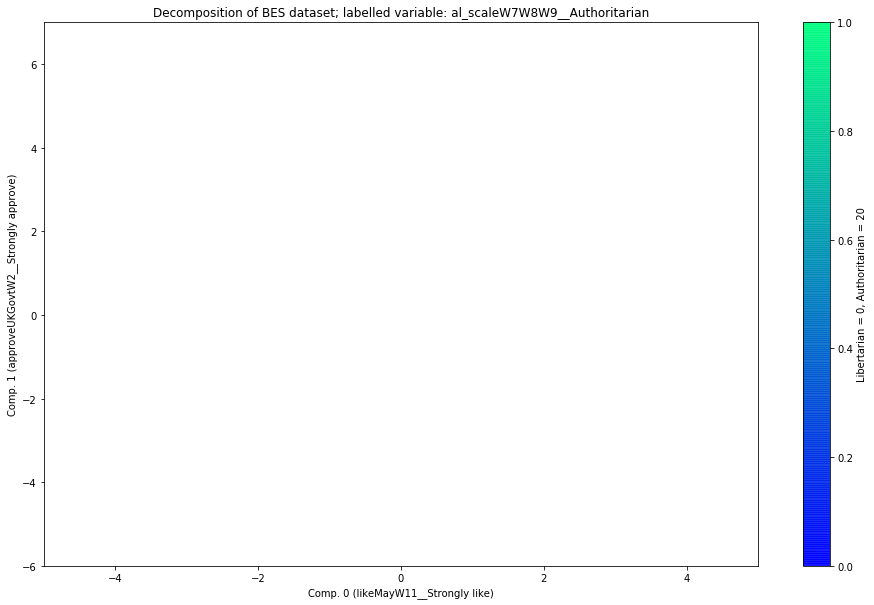

In [26]:
# for ordinal categorical
# winter, autumn
%matplotlib inline
cmap_name = "winter"
decomp_label_col = value_selector.value
label_stub = decomp_label_col.split("__")[0]

fig = plt.figure( figsize=(16,10) )
plt.scatter(BES_decomp.loc[ :, x_axis ],
            BES_decomp.loc[ :, y_axis ],
            cmap = plt.get_cmap(cmap_name),
            c = BES_reduced_with_na.loc[BES_decomp.index,decomp_label_col].values,
            edgecolor = "None",
            alpha = 0.9) #            edgecolors=col,

plt.xlim(xlim) #cats
plt.ylim(ylim)
if label_stub in cat_dictionary.keys():
    cats = cat_dictionary[ label_stub ]
    labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
    plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.show()

fig.savefig( output_subfolder + decomp_method+ os.sep +label_stub+".png", bbox_inches='tight' )

In [27]:
# # for ordinal categorical
# # winter, autumn
# cmap_name = "winter"
# decomp_label_col = 'al_scale__Authoritarian'
# label_stub = decomp_label_col.split("__")[0]

# fig = plt.figure( figsize=(16,10) )
# plt.scatter(BES_decomp.loc[ :, x_axis ],
#             BES_decomp.loc[ :, y_axis ],
#             cmap = plt.get_cmap(cmap_name),
#             c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
#             edgecolor = "None",
#             alpha = 0.9) #            edgecolors=col,

# plt.xlim(xlim)
# plt.ylim(ylim)

# cats = cat_dictionary[ label_stub ]
# labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
# plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
# plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
# plt.xlabel( comp_labels[x_axis] )
# plt.ylabel( comp_labels[y_axis] ) 
# plt.show()

# fig.savefig( BES_data_folder+Treatment+decomp_method+label_stub+".png", bbox_inches='tight' )

,noise_variance_
newspaperW12_Other local daily morning newspaper,0.170241
profile_newspaperW10_Other local daily morning newspaper,0.195373
profile_newspaperW13_Other local daily morning newspaper,0.207975
happyEULeaveW10__Extremely happy,0.214238
likeConW7__Strongly like,0.216135
lr_scaleW6__Right,0.216281
likeUKIPW9__Strongly like,0.217945
happyEULeaveW11__Extremely happy,0.218661
likeConW11__Strongly like,0.220097
likeCameronW6__Strongly like,0.227065


,noise_variance_
askVoteOtherW2_Yes,0.905333
countryOfBirth_Northern Ireland,0.908167
education_CSE grades 2-5,0.905854
education_City and Guild certificate - advanced,0.914580
education_Clerical and commercial,0.900120
"education_Nursing qualification (eg SEN, SRN, SCM, RGN)",0.919548
education_Recognised trade apprenticeship completed,0.915779
education_Scottish Ordinary/ Lower Certificate,0.914861
education_Teaching qualification (not degree),0.914548
education_University diploma,0.908942


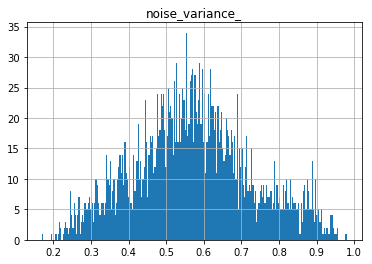

In [28]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
        NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
        display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

In [29]:
# # who are the "improbables"?

# if hasattr(decomp, 'score_samples'):
#     most_likely = pd.DataFrame(decomp.score_samples(BES_std)).quantile(.999).values[0]
#     least_likely = pd.DataFrame(decomp.score_samples(BES_std)).quantile(.001).values[0]
#     print("least likely")
#     display(BES_num_and_cat.loc[ BES_reduced.index[decomp.score_samples(BES_std)<least_likely] ])
# # who are the "stereotypes"?
#     print("most likely")
#     display(BES_num_and_cat.loc[ BES_reduced.index[decomp.score_samples(BES_std)>most_likely ] ])
# # check to see balance of missing values!

In [30]:
###### CLUSTERING ##############

In [31]:

# affinity_propagation = cluster.AffinityPropagation(damping=.9,
#                                                    preference=-200)

# affinity_propagation.fit(X[:,0:2])

# dbscan = cluster.DBSCAN(eps=.2)
# dbscan.fit(X)

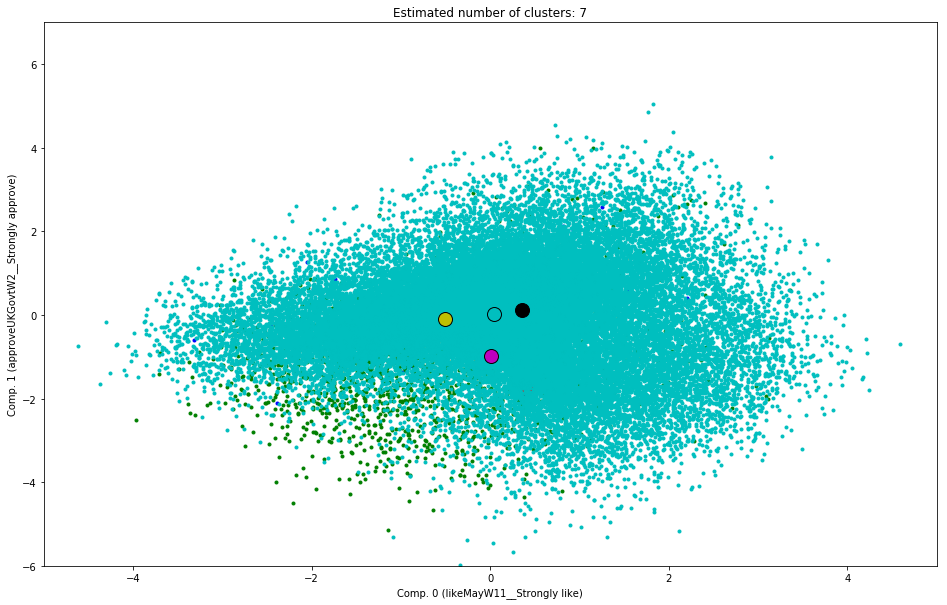

In [32]:
from sklearn import cluster
X = X_r

two_means = cluster.MiniBatchKMeans(n_clusters=7)
two_means.fit(X)

labels = two_means.labels_
cluster_centers = two_means.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

fig = plt.figure( figsize=(16,10) )
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, x_axis], X[my_members, y_axis], col + '.')
    plt.plot(cluster_center[x_axis], cluster_center[y_axis], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
plt.xlim(xlim)
plt.ylim(ylim)
    
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Estimated number of clusters: %d' % n_clusters_)

In [33]:
import numpy as np
from sklearn.cluster import KMeans

def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters, n_jobs=-1)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

In [34]:
labels, centroids, X_hat = kmeans_missing(BES_reduced_with_na, n_clusters=5)

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\sklearn\cluster\k_means_.py:893: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [35]:
gc.collect()

6

number of estimated clusters : 1
Wall time: 2min


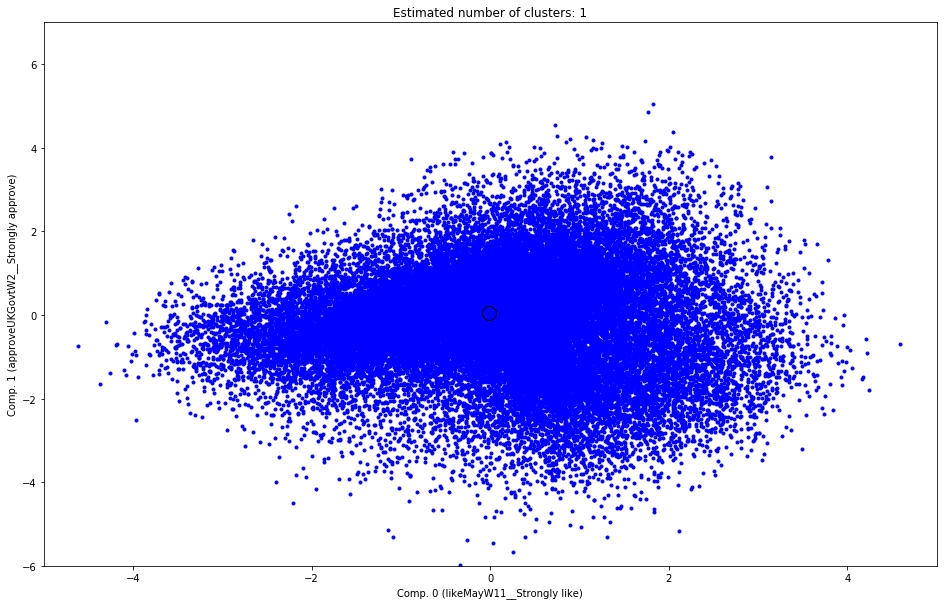

In [36]:
%%time
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

X = X_r

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


fig = plt.figure( figsize=(16,10) )
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, x_axis], X[my_members, y_axis], col + '.')
    plt.plot(cluster_center[x_axis], cluster_center[y_axis], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
plt.xlim(xlim)
plt.ylim(ylim)
    
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

fig.savefig(output_subfolder + decomp_method+ os.sep +"Cluster_estimation.png",bbox_inches='tight')


In [37]:
colours = cycle('ycmkgbr')
markers = cycle('v^<>,oD*x+')

cat_col_mar_dict = {} # category-colour-marker dictionary
# basic set of common ones! 
cat_col_mar_dict['Conservative'] = ('b', '.')
cat_col_mar_dict['Conservative Party'] = ('b', '.')
cat_col_mar_dict['The Conservative candidate']       = ('b', '.')
cat_col_mar_dict['Labour']       = ('r', '.')
cat_col_mar_dict['Labour Party']       = ('r', '.')
cat_col_mar_dict['The Labour candidate']       = ('r', '.')
cat_col_mar_dict['Green Party']  = ('g', '.')
cat_col_mar_dict['The Green candidate']       = ('g', '.')
cat_col_mar_dict['Plaid Cymru']  = ('k', '.')
cat_col_mar_dict['The Plaid Cymru candidate']  = ('k', '.')
cat_col_mar_dict['Scottish National Party']           = ('c', '.')
cat_col_mar_dict['United Kingdom Independence Party'] = ('m', '.')
cat_col_mar_dict['The UKIP candidate'] = ('m', '.')
cat_col_mar_dict['Liberal Democrat']                         = ('orange', '.')
cat_col_mar_dict['Liberal Democrats']                        = ('orange', '.')
cat_col_mar_dict['The Liberal Democrat candidate']                         = ('orange', '.')

In [38]:
# BES_reduced.columns

In [39]:
# BES_Panel["riskScale"]

In [40]:
# [ x for x in BES_reduced.columns if re.match(decomp_label_col + "(__)?", x) ]

# # re.match(decomp_label_col + "__", )

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


riskScaleW8
Age
personality_agreeableness
personality_conscientiousness
personality_extraversion
personality_neuroticism
personality_openness


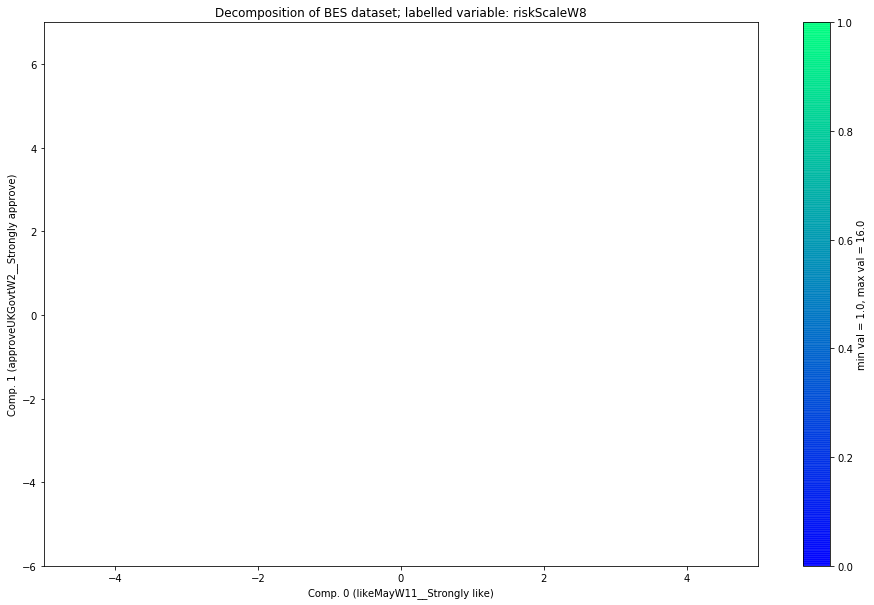

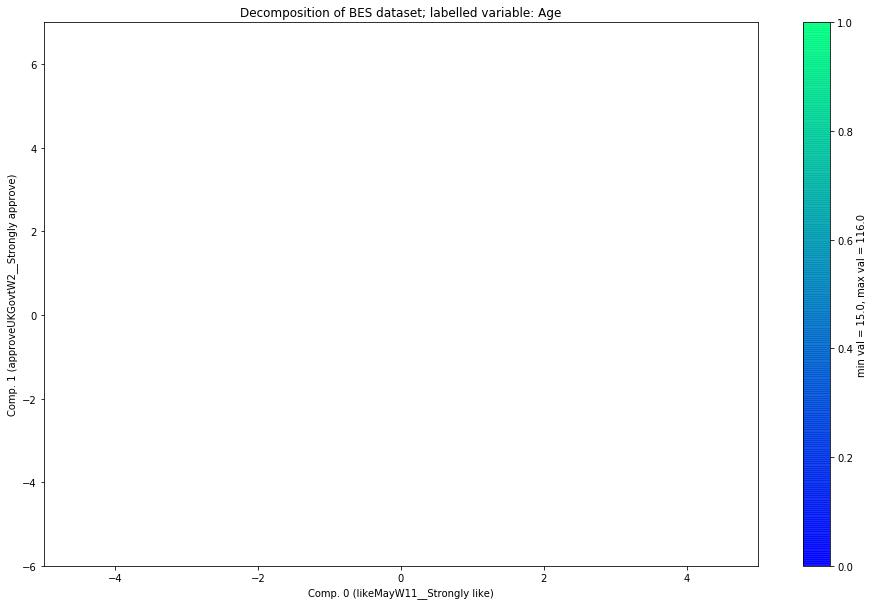

In [41]:
# %%time

graph_type = "ordinal_scatter/"
folder = output_subfolder + decomp_method +os.sep+ graph_type
if not os.path.exists(folder):
    os.makedirs(folder)
    

cmap_name = "winter"
    
dummy_list = var_type[ [ x in [ 0, 1, 2, 5, 6 ] for x in var_type["type"]  ] ].index # 0, 1, 2, 5, 6.index # ordinal variables

# ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:

#     if decomp_label_col in ["profile_religion","country",
#                             'polKnowMay','polKnowOsborne',
#                             'polKnowClegg', 'polKnowBercow',
#                             'polKnowMiliband', 'registered', 'ns_sec']:
#         continue
    
    fig = plt.figure( figsize=(16,10) )

#     # go through all the variables that have been created from base variables through transformation
#     # for ordinal variables, these should only ever be unique matches (unlike non-ordinals)
#     decomp_label_categories = [ x for x in BES_reduced.columns if re.match(decomp_label_col + "_?_?", x) ]
#     if len(decomp_label_categories) == 0: # removed during transformation/reduction
#         continue
#     elif len(decomp_label_categories) > 1:
#         raise Exception('len(decomp_label_categories) > 1 !!!')
#     # c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
    
    #### NEEDS FIXING!!!
    
    if (decomp_label_col not in BES_reduced.columns):
        if decomp_label_col in new_old_col_names.keys(): # variable renamed in transformation
            decomp_label_categories = new_old_col_names[decomp_label_col]
        else:
            continue ## variable removed in transformation
    else:
        decomp_label_categories = decomp_label_col
    
    label_stub = decomp_label_col

    plt.scatter(BES_decomp.loc[ :, x_axis ],
                BES_decomp.loc[ :, y_axis ],
                cmap = plt.get_cmap(cmap_name),
                c = BES_reduced.loc[ BES_decomp.index , decomp_label_categories],
                edgecolor = "None",
                alpha = 0.9) #            edgecolors=col,

    plt.xlim(xlim)
    plt.ylim(ylim)

    # get category labels for categorical variables
    if var_type.loc[label_stub,"type"] in [ 1, 2, 5 ]: #6 already numerical
        cats = cat_dictionary[ label_stub ]
        labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
    elif var_type.loc[label_stub,"type"] in [ 0, 6 ]:
        vals = BES_reduced.loc[ BES_decomp.index , decomp_label_categories]
        labels = ( "min val", min(vals), "max val", max(vals) )
    else:
        raise Exception('var_type not in [ 0, 1, 2, 5, 6]')
        
    plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
    plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
    plt.xlabel( comp_labels[x_axis] )
    plt.ylabel( comp_labels[y_axis] ) 
#     plt.show()
    print(decomp_label_col)
    fig.savefig( folder+decomp_label_col, bbox_inches='tight' )
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1
#     print(fig_no)

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Wall time: 3min 59s


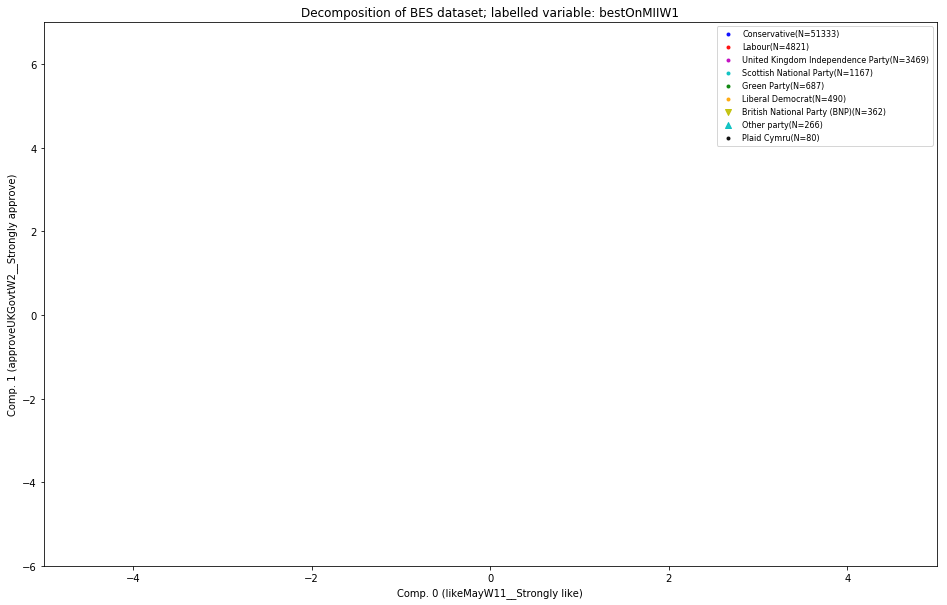

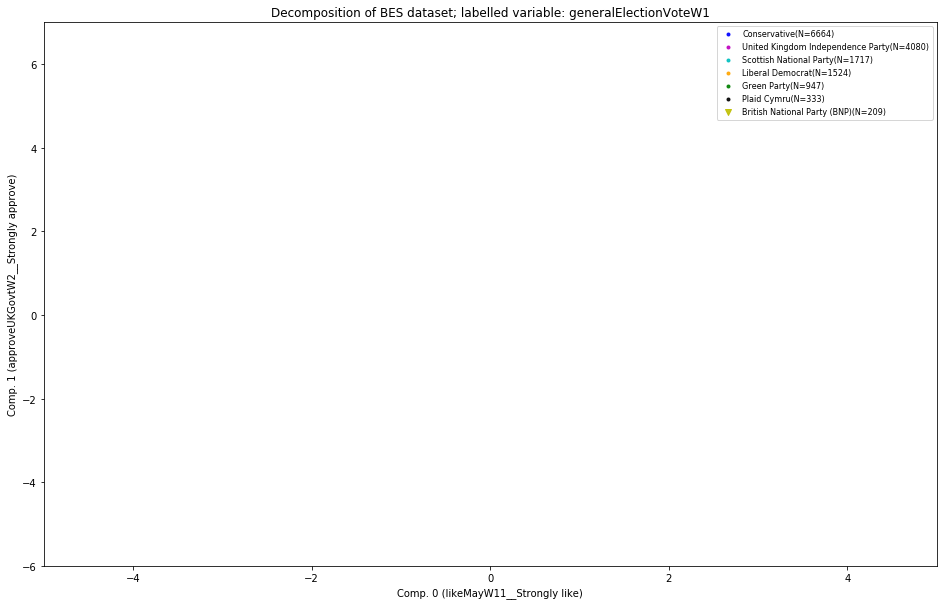

In [42]:
%%time

graph_type = "non_ordinal_scatter/"
folder = output_subfolder + decomp_method +os.sep+ graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ var_type["type"]==3 ].index

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered', 'ns_sec']:
        continue
    
    fig = plt.figure( figsize=(16,10) )

    decomp_label_categories = [ x for x in BES_reduced.columns if (decomp_label_col + "_") in x ]
    if len(decomp_label_categories) == 0:
        continue
        
#     if (decomp_label_col not in BES_reduced.columns):
#         if decomp_label_col in new_old_col_names.keys(): # variable renamed in transformation
#             decomp_label_categories = new_old_col_names[decomp_label_col]
#         else:
#             continue ## variable removed in transformation
#     else:
#         decomp_label_categories = decomp_label_col        

    # 'No party is best able to handle this issue'
    drop_cat_list = ['profile_education_age', 'profile_ethnicity_White British']
    for drop_cat in drop_cat_list:
        if drop_cat in decomp_label_categories:
            decomp_label_categories.remove(drop_cat)
            
    replace_dict = {'Scottish National Party (SNP)' : 'Scottish National Party',
                    'United Kingdom Independence Party (UKIP)' : 'United Kingdom Independence Party'}

    lab_to_cat = {}
    sample_sizes = {}
    for cat in decomp_label_categories:
        
        lab = re.search('_([^_]+)$',cat).groups()[0]
        if lab in replace_dict.keys(): # replace party name variants with single version
            lab = replace_dict[lab]
        
        if lab not in cat_col_mar_dict.keys(): # try to give parties consistent colour, marker pairs
            cat_col_mar_dict[lab] = (next(colours),next(markers))
        
        sample_sizes[lab] = sum( BES_reduced[ cat ]==1 )
        lab_to_cat[lab] = cat

    for lab in sorted(sample_sizes, key=sample_sizes.get, reverse=True):
        
        samp = sample_sizes[lab]
            
        (col, mar) = cat_col_mar_dict[lab]

        cat_entries = BES_reduced[ lab_to_cat[lab] ]==1
        
        plt.scatter(BES_decomp.loc[ cat_entries, x_axis ],
                    BES_decomp.loc[ cat_entries, y_axis ],
                    c= col,
                    marker=mar,
                    label=lab + "(N="+str(samp)+")",
                    edgecolors=col,
                    alpha = .9 )
    
    plt.xlim(xlim)
    plt.ylim(ylim)    
    
    plt.xlabel( comp_labels[x_axis] )
    plt.ylabel( comp_labels[y_axis] ) 
    plt.legend(prop={'size':8})
    plt.title('Decomposition of BES dataset; labelled variable: ' + decomp_label_col)
    
    fig.savefig( folder+decomp_label_col, bbox_inches='tight' )
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

In [43]:
# col = "euRefVote"

# df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
# max_cols = 4

# # reduce length of subcategories
# cats = list(cat_dictionary[col])
# for catno in range( len( cats ) ):

#     words = cats[catno].split(" ")
#     word_array = np.array( [len(x) for x in words] ) + 1
#     max_words = np.where( np.cumsum( word_array )<25 )[0].max()
#     cats[catno] = " ".join( words[0:max_words+1] )


# # add a category column to split the graphs on
# df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

# # add N=??? sample size to each category type!
# sample_sizes = df[col].value_counts().loc[cats].values
# cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
# df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

# # formatting
# n_cols = len(df[col].dropna().unique())
# n_rows = np.ceil(n_cols/max_cols)
# col_wrap = min(max_cols,n_cols)
# size = 13.5/col_wrap

# # make the actual graphs
# g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
# g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

# # plt.xlim(xlim)
# # plt.ylim(ylim)   
# # plt.xlim(-3, 3)  
# # plt.ylim(-3, 3)

# # labels and title
# plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
# g.set_xlabels( comp_labels[x_axis] )
# g.set_ylabels( comp_labels[y_axis] ) 
# g.fig.suptitle(col, fontsize=14, fontweight='bold')

# # save to file
# g.savefig(BES_data_folder+Treatment+decomp_method+col+"_kde", bbox_inches='tight')

In [44]:
# BES_numeric['riskScale'].astype('category')
# df[col].value_counts()
# [str(x) for x in df[col].cat.categories]
# df[col].value_counts().values

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\statsmodels\nonparametric\bandwidths.py:22: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)


ZeroDivisionError: 0.0 cannot be raised to a negative power

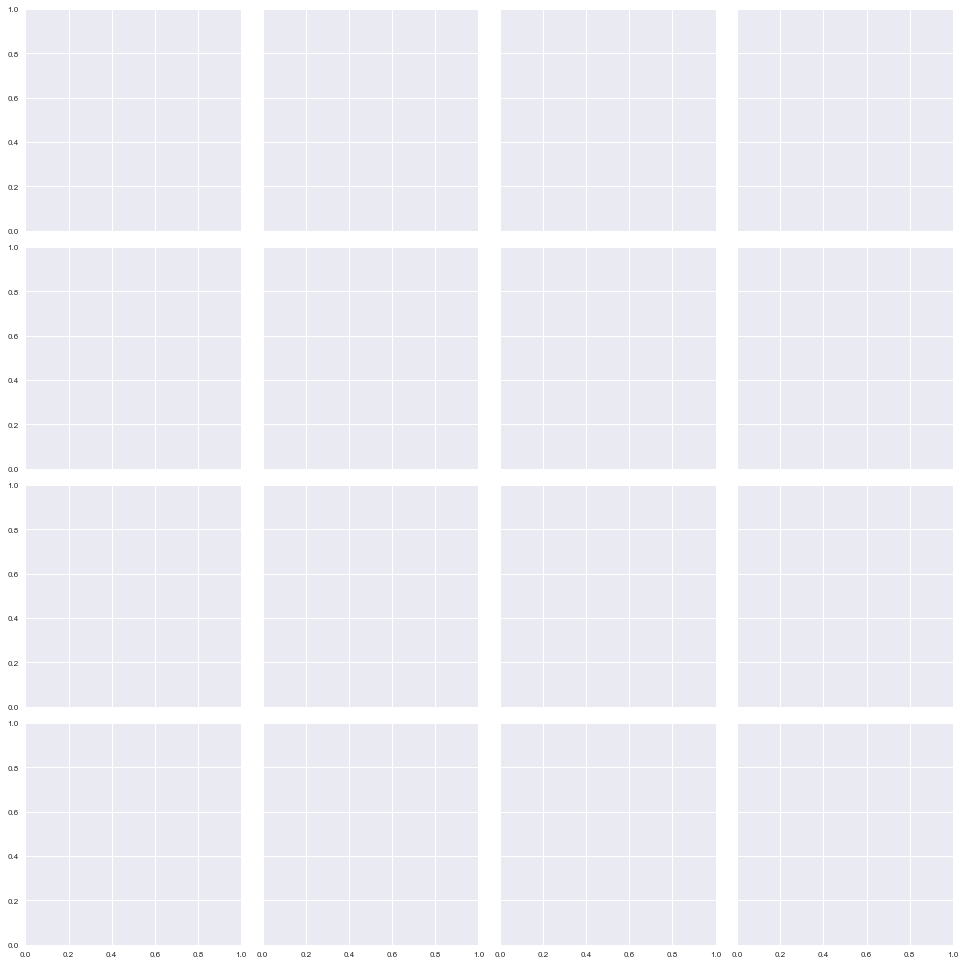

In [45]:
%%time

graph_type = "ordinal_kde/"
folder = output_subfolder + decomp_method +os.sep+ graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ [ x in [ 0 ] for x in var_type["type"]  ] ].index # , 1, 2, 5, 6

sns.set(font_scale=.8)

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered',
                            'country_of_residence1','country_of_residence2',
                           'polKnowMiliband', 'polKnowClegg',
       'polKnowOsborne', 'polKnowMay', 'polKnowBercow',
'polKnowKerryW9',
       'polKnowHollandeW9', 'polKnowNetanyahuW9', 'polKnowPutinW9',
       'polKnowMerkelW9', 'polKnowAssadW9', 
       'ns_sec', 'EUMIICategory', 'age', 'Age', 'euRefExpectation',
       'country_of_residence2', 'country_of_residence1', 'profile_lea',
       'profile_oslaua', 'pano',
                           'EUMIICategory']:
        continue
    
#     col = "euRefVote"
#     fig = plt.figure( figsize=(16,10) )
    col = decomp_label_col

    df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
    max_cols = 4

#     # get category labels for categorical variables
#     if var_type.loc[label_stub,"type"] in [ 1, 2, 5, 6 ]:
#         cats = cat_dictionary[ label_stub ]
#         labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
#     elif var_type.loc[label_stub,"type"] in [ 0 ]:
#         vals = BES_reduced.loc[ BES_decomp.index , decomp_label_categories[0] ].values
#         labels = ( "min val", min(vals), "max val", max(vals) )
#     else:
#         raise Exception('var_type not in [ 0, 1, 2, 5, 6]')    
    
    if var_type.loc[col,"type"] in [ 1, 2, 5, 6 ]:
    
        # reduce length of subcategories
        cats = list(cat_dictionary[col])
        for catno in range( len( cats ) ):

            words = cats[catno].split(" ")
            word_array = np.array( [len(x) for x in words] ) + 1
            max_words = np.where( np.cumsum( word_array )<30 )[0].max()
            cats[catno] = " ".join( words[0:max_words+1] )
        # NOTE - can cause problems if 2+ truncated subcategories are identical

        # add a category column to split the graphs on
        df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

        # add N=??? sample size to each category type!
        sample_sizes = df[col].value_counts().loc[cats].values        
    elif var_type.loc[col,"type"] in [ 0 ]:
        df[col] = BES_numeric[col].astype('category')
        cats = [str(x) for x in df[col].cat.categories]
        # add N=??? sample size to each category type!
        sample_sizes = df[col].value_counts().values          
    else:
        raise Exception('var_type not in [ 0, 1, 2, 5, 6]')          
        

    cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
    df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

    # formatting
    n_cols = len(df[col].dropna().unique())
    n_rows = np.ceil(n_cols/max_cols)
    col_wrap = min(max_cols,n_cols)
    size = 13.5/col_wrap

    # make the actual graphs
    g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
    g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

    plt.xlim(xlim)
    plt.ylim(ylim)   
    # plt.xlim(-3, 3)  
    # plt.ylim(-3, 3)

    # labels and title
    plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
    g.set_xlabels( comp_labels[x_axis] )
    g.set_ylabels( comp_labels[y_axis] ) 
    g.fig.suptitle(col, fontsize=14, fontweight='bold')

    # save to file
    g.savefig(folder +os.sep+ col+"_kde", bbox_inches='tight')
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\statsmodels\nonparametric\bandwidths.py:22: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)


ZeroDivisionError: 0.0 cannot be raised to a negative power

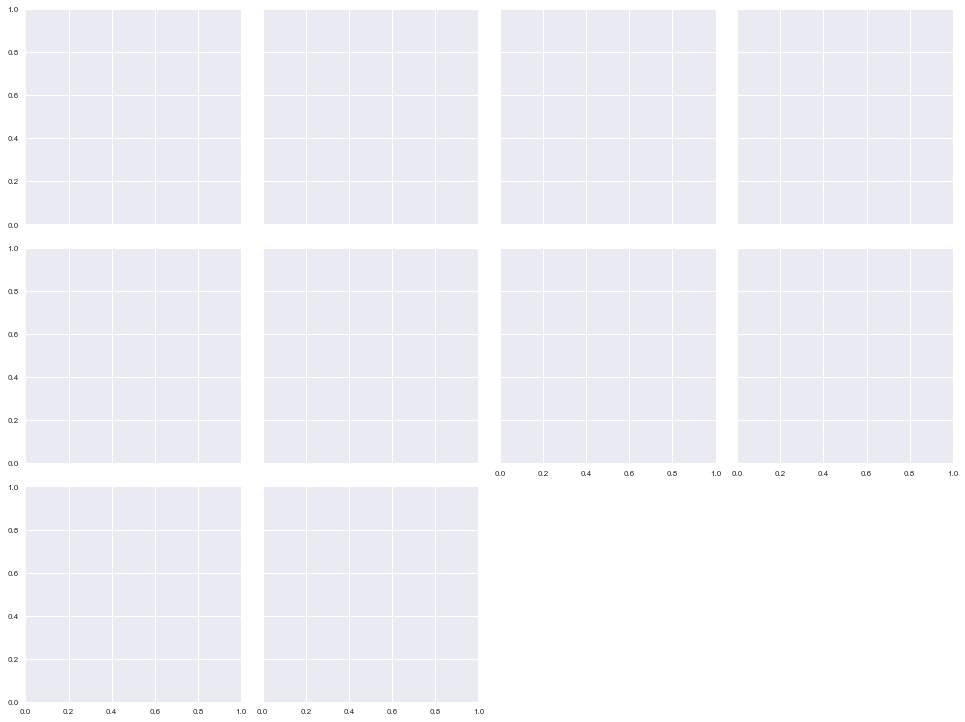

In [46]:
%%time
# 10 minutes!
max_cats = 30 # maximum number of categories

graph_type = "non_ordinal_kde/"
folder = output_subfolder + decomp_method +os.sep+ graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ var_type["type"]==3 ].index

sns.set(font_scale=.8)

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered',
                            'country_of_residence1','country_of_residence2',
                           'polKnowMiliband', 'polKnowClegg',
       'polKnowOsborne', 'polKnowMay', 'polKnowBercow',
'polKnowKerryW9',
       'polKnowHollandeW9', 'polKnowNetanyahuW9', 'polKnowPutinW9',
       'polKnowMerkelW9', 'polKnowAssadW9', 
       'ns_sec', 'EUMIICategory', 'age', 'Age', 'euRefExpectation',
       'country_of_residence2', 'country_of_residence1', 'profile_lea',
       'profile_oslaua', 'pano',
                           'EUMIICategory']:
        continue
    
#     col = "euRefVote"
#     fig = plt.figure( figsize=(16,10) )
    col = decomp_label_col

    df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
    max_cols = 4

    # reduce length of subcategories
    # so it only contains categories *that exist in this column*
    cats = list( cat_dictionary[col][ list(BES_numeric[col].astype('category').cat.categories.astype('int')) ] )
    
    num_cats = len( cats )
    
    if num_cats > max_cats:
        print(col,"has more than max_cats categories",max_cats,"so skipping")
        continue
    
    for catno in range( num_cats ):

        words = cats[catno].split(" ")
        word_array = np.array( [len(x) for x in words] ) + 1
        max_words = np.where( np.cumsum( word_array )<30 )[0].max()
        cats[catno] = " ".join( words[0:max_words+1] )
    # NOTE - can cause problems if 2+ truncated subcategories are identical

    # add a category column to split the graphs on
    df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

    # add N=??? sample size to each category type!
    sample_sizes = df[col].value_counts().loc[cats].values
    cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
    df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

    # formatting
    n_cols = len(df[col].dropna().unique())
    n_rows = np.ceil(n_cols/max_cols)
    col_wrap = min(max_cols,n_cols)
    size = 13.5/col_wrap

    # make the actual graphs
    g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
    g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

    plt.xlim(xlim)
    plt.ylim(ylim)   
    # plt.xlim(-3, 3)  
    # plt.ylim(-3, 3)

    # labels and title
    plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
    g.set_xlabels( comp_labels[x_axis] )
    g.set_ylabels( comp_labels[y_axis] ) 
    g.fig.suptitle(col, fontsize=14, fontweight='bold')

    # save to file
    g.savefig(folder +os.sep+ col+"_kde", bbox_inches='tight')
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

In [58]:
col

'bestOnMIIW1'

C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\seaborn\distributions.py:630: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\statsmodels\nonparametric\bandwidths.py:22: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\matplotlib\contour.py:1514: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\Marios\AppData\Local\conda\conda\envs\BES_analysis\lib\site-packages\matplotlib\contour.py:1515: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


Wall time: 47.2 s


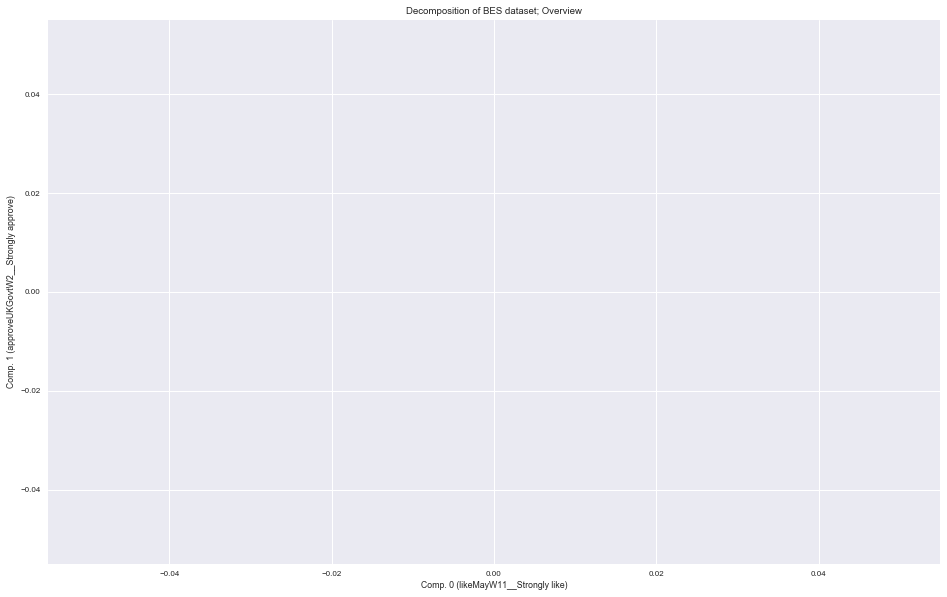

In [47]:
%%time
# col = "edlevel"

# df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
# max_cols = 4

# # reduce length of subcategories
# cats = list(cat_dictionary[col])
# for catno in range( len( cats ) ):

#     words = cats[catno].split(" ")
#     word_array = np.array( [len(x) for x in words] ) + 1
#     max_words = np.where( np.cumsum( word_array )<25 )[0].max()
#     cats[catno] = " ".join( words[0:max_words+1] )


# add a category column to split the graphs on
# df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

# # add N=??? sample size to each category type!
# sample_sizes = df[col].value_counts().loc[cats].values
# cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
# df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

# # formatting
# n_cols = len(df[col].dropna().unique())
# n_rows = np.ceil(n_cols/max_cols)
# col_wrap = min(max_cols,n_cols)
# size = 13.5/col_wrap

# make the actual graphs
# g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
fig = plt.figure( figsize=(16,10) )
sns.kdeplot(BES_decomp.loc[ : , [x_axis,y_axis] ],
            shade=True, shade_lowest=False, n_levels=20) #, shade=True, shade_lowest=False)
# g.set_titles("{col_name}")

# plt.xlim(xlim)
# plt.ylim(ylim)   
# plt.xlim(-3, 3)  
# plt.ylim(-3, 3)

# labels and title
# plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
# g.set_xlabels( comp_labels[x_axis] )
# g.set_ylabels( comp_labels[y_axis] ) 
# g.fig.suptitle(col, fontsize=14, fontweight='bold')
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Decomposition of BES dataset; Overview')
# save to file
fig.savefig(output_subfolder + decomp_method + os.sep + "overview"+"_kde", bbox_inches='tight')

In [48]:
col

'bestOnMIIW1'

In [49]:
# %%time
# # Load BES Panel for Wave 8
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta") # 130Mb
# #(31409, 733)

# # BES_Panel = pd.read_stata(BES_data_folder+BES2015_W8_v1.6.dta")

# print( BES_Panel.shape )

In [50]:
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
# weights = BES_Panel['wt_full_W8']
# print(weights.shape)

# samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
# samples = np.swapaxes(samples,0,1)
# print(samples.shape)

In [51]:
# #create mesh grid
# x = np.linspace(xlim[0], xlim[1], 100)
# y = np.linspace(ylim[0], ylim[1], 100)
# xx, yy = np.meshgrid(x, y)

In [52]:
# #Evaluate the kde on a grid
# pdf = gaussian_kde(samples.values, weights=weights.values)
# zz = pdf((np.ravel(xx), np.ravel(yy)))
# zz = np.reshape(zz, xx.shape)

In [53]:
# gc.collect()

In [54]:
# kwargs = dict(extent=(xlim[0], xlim[1], ylim[0], ylim[1]), cmap='hot', origin='lower')

In [55]:
# plt.figure()
# plt.imshow(zz, **kwargs)
# plt.title('kde')
# plt.tight_layout()
# plt.show()

In [56]:
# from matplotlib import mlab, cm
# levels = np.arange(0, 0.16, 0.01)  # Boost the upper limit to avoid truncation errors.
# norm = cm.colors.Normalize(vmax=abs(zz).max(), vmin=-abs(zz).max())
# cmap = cm.PRGn
# cset1 = plt.contourf(xx, yy, zz, levels,
#                  cmap=cm.get_cmap(cmap, len(levels) - 1),
#                  norm=norm,
#                  )

In [57]:
%%time
BES_Panel = pd.read_stata( data_subfolder + filename )
# weights = BES_Panel['wt_full_W8']
if 
weights = BES_Panel['wt_core_W8'].dropna()
print(weights.shape)

# samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
samples = BES_decomp.loc[ BES_Panel['wt_core_W8'].notnull() , [x_axis,y_axis] ]
samples = np.swapaxes(samples,0,1)
print(samples.shape)


weighted_kde(xlim, ylim, samples, weights)

SyntaxError: invalid syntax (<unknown>, line 3)

In [ ]:
# thresh = .2
# counts = BES_numeric.count()
# mostly_not_filled_out = counts[counts<= (counts.max()*thresh)].index
# # mostly_filled_out     = counts[counts>  (counts.max()*thresh)].index
# W9_vars = pd.Index([x for x in BES_numeric.columns if "W9" in x])

# many_cat_drop_list = ['Age', 'EUMIICategory', 'age', 'country_of_residence1',
#        'country_of_residence2', 'euRefExpectation', 'ns_sec', 'pano',
#        'profile_lea', 'profile_oslaua']

# high_corr_drop_list = ['ageGroup', 'euRefVote2', 'euRefVotePost', 'euRefVoteUnsqueeze',
#        'recallVote15', 'voted2015']

# very_low_var = ['partyContactLD_6', 'partyContactLD_7', 'partyContactUKIP_1']

# BES_reduced = BES_numeric.copy()
# BES_reduced.drop(W9_vars,               axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(mostly_not_filled_out, axis=1, inplace=True, errors='ignore')
# # BES_reduced.drop(many_cat_drop_list   , axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(high_corr_drop_list  , axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(very_low_var         , axis=1, inplace=True, errors='ignore')
# print(BES_reduced.shape)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import seaborn; seaborn.set() # set plot style

# https://github.com/jakevdp/wpca
# https://github.com/jakevdp/wpca/blob/master/WPCA-Example.ipynb
from wpca import PCA, WPCA, EMPCA

In [ ]:
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
# weights = BES_Panel['wt_full_W8']
row_weights = BES_non_numeric['wt_new_W13'].copy()#.dropna()
#BES_Panel['wt_full_W8'].dropna()

# there's a nan right at this point and nowhere else!
row_weights.loc[5987] = 1.0

print(row_weights.shape)

# # samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
# samples = BES_decomp.loc[ BES_Panel['wt_core_W8'].notnull() , [x_axis,y_axis] ]
# samples = np.swapaxes(samples,0,1)
# print(samples.shape)


demographic_moderator = 5

row_weights = ((row_weights-1)/demographic_moderator) + 1


row_weights.hist(bins=200)
print( row_weights.min(),row_weights.max() )

In [ ]:
# subsample
# BES_reduced = BES_reduced_with_na[BES_reduced_with_na.columns[0:200]][0:30000].copy()

# BES_reduced = BES_reduced_with_na.copy()
# BES_reduced = BES_reduced.copy()
missing_value_matrix = BES_reduced_with_na.notnull().astype('int')
missing_value_matrix[missing_value_matrix==0] = .25


In [ ]:
# multiply binary null/notnull matrix by the weights for each row (individual)
weights = missing_value_matrix.apply(lambda x: x*row_weights)
# weights = BES_reduced.notnull().astype('int') # just missing values
# weights = missing_value_matrix
weights = weights/weights.mean().mean()

In [ ]:
clean_feature_set_std = StandardScaler().fit_transform(BES_reduced.values )

In [ ]:
# "weightPCAreduced_withPP/" - 2% reduced data
# "weightPCAreduced_withPP/"
# Treatment = "weightPCAuptodate"
# Treatment = "sklearnPCAuptodate"
# Treatment = "weightPCAuptodate_weights_just_missing_values"
# Treatment = "EMPCAuptodate_weights_just_missing_values"
# Treatment = "EMPCA_W10_only"
Treatment = "WPCA_W13_only"
if not os.path.exists(BES_data_folder+Treatment):
    os.makedirs(BES_data_folder+Treatment)

In [ ]:
%%time
from wpca import WPCA, EMPCA
from sklearn.decomposition import PCA
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_reduced.columns,
                             index   = BES_reduced.index      )

# decomp = PCA(svd_solver='full')
# #decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#  #    n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# # decomp = SparsePCA(n_components=30, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
# #
# # alpha=2 -> 1hr
# decomp = FactorAnalysis(svd_method = 'lapack') ## ~10s ,n_components=30 -> 1.5 hrs
# # ,n_components=30
# PCA, WPCA, EMPCA
# decomp = PCA(n_components=10)
# decomp = EMPCA() # overnight!
# decomp = WPCA() # 21 minutes, 7min 54s (14min 34s) -> rubbish
# decomp = WPCA(n_components=10) # 6.2s -> rubbish
# decomp = WPCA(n_components=30) # 7min 22s -> rubbish
# decomp = EMPCA(n_components=10) # 6.2s # 20min 29s -> and rubbish
#decomp = EMPCA() # more than 8 hours - had to interrupt
# weights = []

# 20s with weights, 7mins with no weights (weird!)
decomp = EMPCA(n_components=4) # super slow!
#decomp = WPCA(n_components=4) #332ms # (n_components=30)
# decomp = PCA() # svd_solver='full' # 2s


decomp_method = str(decomp).split("(")[0]
# decomp_method = "EWPCA" # 21 minutes
if len(weights) ==0 or decomp_method == "PCA":
    kwds = {}
else:
    kwds = {'weights': weights}

X_r = decomp.fit_transform(BES_std, **kwds)
n_components = decomp.components_.shape[0]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_reduced.index)


In [ ]:
gc.collect()

In [ ]:
subdir = BES_data_folder+"/"+Treatment+"/"+decomp_method+"/"
if not os.path.exists(subdir): os.makedirs(subdir)


In [ ]:
display_pca_data(n_components, decomp, BES_std)

In [ ]:
# %%time
# # BES_decomp, comp_labels, comp_dict = display_components(n_components, decomp, subdir, BES_reduced.columns, BES_decomp)
# (BES_decomp, comp_labels,comp_dict) = display_components(n_components, decomp.components_,
#                                                          subdir + os.sep, BES_reduced.columns, BES_decomp)

# treatdir = BES_data_folder+"W13_Lab_lost"
# if not os.path.exists(treatdir): os.makedirs(treatdir)

# decomp_method = str(decomp).split("(")[0] 
# decomp_method_subdir = treatdir + os.sep + decomp_method
# if not os.path.exists(decomp_method_subdir): os.makedirs(decomp_method_subdir)
    
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_reduced.columns, BES_decomp,
                                                          save_folder = subdir, 
                                                          show_first_x_comps= 20, show_histogram = True)



In [ ]:
W5vars = [x for x in BES_reduced.columns if "W5" in x]

In [ ]:
len(W5vars)

In [ ]:
# W5corr = BES_non_numeric["CampaignDayW5"].corr( BES_reduced[W5vars] )
W5corr = BES_reduced[W5vars].corrwith(BES_non_numeric["CampaignDayW5"])
# BES_non_numeric["CampaignDayW5"].corr(  )

In [ ]:
W5corr.sort_values(ascending=False)

In [ ]:
var_list = W5corr.abs().sort_values(ascending=False).head(60).index

In [ ]:
[x for x in BES_reduced.columns if "likeBennett" in x]


In [ ]:
variable = 'likeBennettW5__Strongly like'
# "labPartnerSNPW5_Would join Labour"
crosstab = pd.crosstab(index   = BES_non_numeric[ "CampaignDayW5" ],
                       columns = BES_reduced[ variable ],
                       values  = BES_non_numeric[ "wt_daily_W5" ],
                       aggfunc = sum,
                       normalize='index')

x_axis = "Campaign Day"
y_axis = variable
x_dim = hv.Dimension(x_axis, values = crosstab.index)
y_dim = hv.Dimension(y_axis, unit = '%')#, soft_range = (0,100))
hv.Curve(crosstab.unstack() * 100,
                           kdims = [x_dim] ,
                           vdims = [y_dim] )

In [ ]:
( x for x in zip(range(0, int(BES_reduced[ variable ].max())),crosstab.columns) )

In [ ]:
hmap_of_curves =  hv.HoloMap(kdims=['$variable$'])

# var_list = ['likeBennettW5__Strongly like', "labPartnerSNPW5_Would join Labour"]
var_list = W5corr.abs().sort_values(ascending=False).head(60).index

for var_no in range(len(var_list)):
#     print(variable)
    variable = var_list[var_no]

    crosstab = pd.crosstab(index   = BES_non_numeric[ "CampaignDayW5" ],
                           columns = BES_reduced[ variable ],
                           values  = BES_non_numeric[ "wt_daily_W5" ],
                           aggfunc = sum,
                           normalize='index')
#     crosstab.columns = cat_dictionary[new_old_col_names[variable]]    

#     curves = hv.NdOverlay(key_dimensions=['$stuff$'] )
    
#     for value in range(0, 1+int(BES_reduced[ variable ].max()) ):
# #         col_variable = crosstab.columns[value]
#         curves[value] = hv.Curve(crosstab[value]*100,
#                                 kdims=['$x$'],
#                                 vdims=['$\\phi(x;stuff)$'], label = variable) 
#     hmap_of_curves[var_no] = curves
    col_variable = int(BES_reduced[ variable ].max())
    hmap_of_curves[var_no] = hv.Curve( crosstab[col_variable] * 100,
                                kdims=['$x$'],
                                vdims=['$\\phi(x;stuff)$'], label = variable)
    
hmap_of_curves

In [ ]:
    crosstab = pd.crosstab(index   = BES_non_numeric[ "CampaignDayW5" ],
                           columns = BES_reduced[ 'noChanceCoalitionLDW5_Yes' ],
                           values  = BES_non_numeric[ "wt_daily_W5" ],
                           aggfunc = sum,
                           normalize='index')

In [ ]:
[x for x in BES_reduced.columns if "Age" in x]